# Riemannian Score Fréchet Means

In [37]:
from jaxgeometry.manifolds import *
from jaxgeometry.integration import dts, dWs
from jaxgeometry.autodiff import jacfwdx
from jaxgeometry.statistics.score_matching import diffusion_mean as dm_score
from jaxgeometry.statistics import diffusion_mean as dm_bridge
from jaxgeometry.stochastics import Brownian_coords, product_sde, Brownian_sR
from jaxgeometry.stochastics.product_sde import tile
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap
import jax.random as jrandom

import scipy.io as sio

import os

from load_manifold import get_generator_dim, load_manifold

import torch
import torchvision.utils as vutils

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics import Frechet_mean

from jaxgeometry.statistics.score_matching import model_loader, generators
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from models import models

In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
s1loss_type = 'dsm'
s2loss_type = 'dsm'
s2_type = 's1s2'
s2_approx = 0
seed = 2712

t0 = 0.1
score_path = "scores"

In [4]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1T_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}T_{s2loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)
    layers_s1, layers_s2 = layers

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers_s1)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers_s2, layers_beta=layers_s2,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers_s1), 
                    models.MLP_s2(layers_alpha=layers_s2, 
                                  layers_beta=layers_s2,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval

## Score Fréchet Mean

In [5]:
figure_path = '../figures/frechet_mean/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

## Real-World Data

### $\mathcal{P}(3)$

In [6]:
data_path = '../../../Data/spdn/dti_tensor.mat'

In [7]:
mat = sio.loadmat(data_path)

In [8]:
segmentation = jnp.array(mat['segmentation']).reshape(-1)
dti_tensor = jnp.array(mat['dti_tensor']).reshape(-1,6)

In [9]:
dti_tensor0 = dti_tensor[segmentation == 0]
dti_tensor1 = dti_tensor[segmentation == 1]
dti_tensor2 = dti_tensor[segmentation == 2]
dti_tensor3 = dti_tensor[segmentation == 3]

In [10]:
def convert_to_SPDN(x):
    
    upper_index = jnp.triu_indices(n=3)
    
    val = jnp.zeros((3,3))
    val = val.at[upper_index].set(x)
    
    return val+val.T-jnp.diag(jnp.diag(val))

def get_principal_eigenvector(x):
    
    return jnp.linalg.svd(x)[0][:,0]

def get_eigval(x):
    
    return jnp.linalg.svd(x)[1]
    

In [11]:
scaling = 2*1e4
dti_spdn0 = scaling*vmap(lambda x: convert_to_SPDN(x))(dti_tensor0)
dti_spdn1 = scaling*vmap(lambda x: convert_to_SPDN(x))(dti_tensor1)
dti_spdn2 = scaling*vmap(lambda x: convert_to_SPDN(x))(dti_tensor2)
dti_spdn3 = scaling*vmap(lambda x: convert_to_SPDN(x))(dti_tensor3)

In [12]:
dti_eigvec1 = vmap(lambda x: get_principal_eigenvector(x))(dti_spdn1)
dti_eigvec2 = vmap(lambda x: get_principal_eigenvector(x))(dti_spdn2)
dti_eigvec3 = vmap(lambda x: get_principal_eigenvector(x))(dti_spdn3)

dti_eigval1 = vmap(lambda x: get_eigval(x))(dti_spdn1)
dti_eigval2 = vmap(lambda x: get_eigval(x))(dti_spdn2)
dti_eigval3 = vmap(lambda x: get_eigval(x))(dti_spdn3)

In [13]:
M, x0, ScoreEval = load_score_model("SPDN", 3)

using M.Exp for Logarithm


In [14]:
spdn_obs1 = vmap(lambda x: (M.invF((x,x)), x.reshape(-1)))(dti_spdn1)
spdn_obs2 = vmap(lambda x: (M.invF((x,x)), x.reshape(-1)))(dti_spdn2)
spdn_obs3 = vmap(lambda x: (M.invF((x,x)), x.reshape(-1)))(dti_spdn3)

In [15]:
t0 = 0.01
dm_score(M, s1_model=lambda x,y,t: t0*ScoreEval.grady_log(x,y,t), s2_model = ScoreEval.gradt_log, method="Gradient")
spdn_mu1_score_frechet = M.sm_dmx((spdn_obs1[0][:100], spdn_obs1[1][:100]), 
                                     (spdn_obs1[0][0], spdn_obs1[1][0]), 
                                     t0, 
                                     step_size=0.01, max_iter=1000)[0]
spdn_mu2_score_frechet = M.sm_dmx((spdn_obs2[0][:100], spdn_obs2[1][:100]), 
                                     (spdn_obs2[0][0], spdn_obs2[1][0]), 
                                     t0, 
                                     step_size=0.01, max_iter=1000)[0]
spdn_mu3_score_frechet = M.sm_dmx((spdn_obs3[0][:100], spdn_obs3[1][:100]), 
                                     (spdn_obs3[0][0], spdn_obs3[1][0]), 
                                     t0, 
                                     step_size=0.01, max_iter=1000)[0]

In [16]:
spdn_mu1_score_eigval = get_eigval(spdn_mu1_score_frechet[1][-1].reshape(3,3))
spdn_mu2_score_eigval = get_eigval(spdn_mu2_score_frechet[1][-1].reshape(3,3))
spdn_mu3_score_eigval = get_eigval(spdn_mu3_score_frechet[1][-1].reshape(3,3))

In [17]:
dm_score(M, s1_model=lambda x,y,t: M.Log(y, x[1]), s2_model = ScoreEval.gradt_log, method="Gradient")
spdn_mu1_true_frechet = M.sm_dmx((spdn_obs1[0][:100], spdn_obs1[1][:100]), 
                                     (spdn_obs1[0][0], spdn_obs1[1][0]), 
                                     t0, 
                                     step_size=0.01, max_iter=1000)[0]

spdn_mu2_true_frechet = M.sm_dmx((spdn_obs2[0][:100], spdn_obs2[1][:100]), 
                                     (spdn_obs1[0][0], spdn_obs1[1][0]), 
                                     t0, 
                                     step_size=0.01, max_iter=1000)[0]

spdn_mu3_true_frechet = M.sm_dmx((spdn_obs3[0][:100], spdn_obs3[1][:100]), 
                                     (spdn_obs1[0][0], spdn_obs1[1][0]), 
                                     t0, 
                                     step_size=0.01, max_iter=1000)[0]


In [18]:
spdn_mu1_true_eigval = get_eigval(spdn_mu1_true_frechet[1][-1].reshape(3,3))
spdn_mu2_true_eigval = get_eigval(spdn_mu2_true_frechet[1][-1].reshape(3,3))
spdn_mu3_true_eigval = get_eigval(spdn_mu3_true_frechet[1][-1].reshape(3,3))

### Plotting

In [19]:
#S2
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

In [87]:
error = (spdn_mu1_true_frechet[1][-1]-spdn_mu1_score_frechet[1][-1])**2

In [88]:
error

Array([9.70391546e-03, 1.60668611e-04, 1.01964348e-04, 1.60668611e-04,
       1.54317403e-02, 8.27354778e-05, 1.01964348e-04, 8.27354778e-05,
       1.11339789e-02], dtype=float64)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


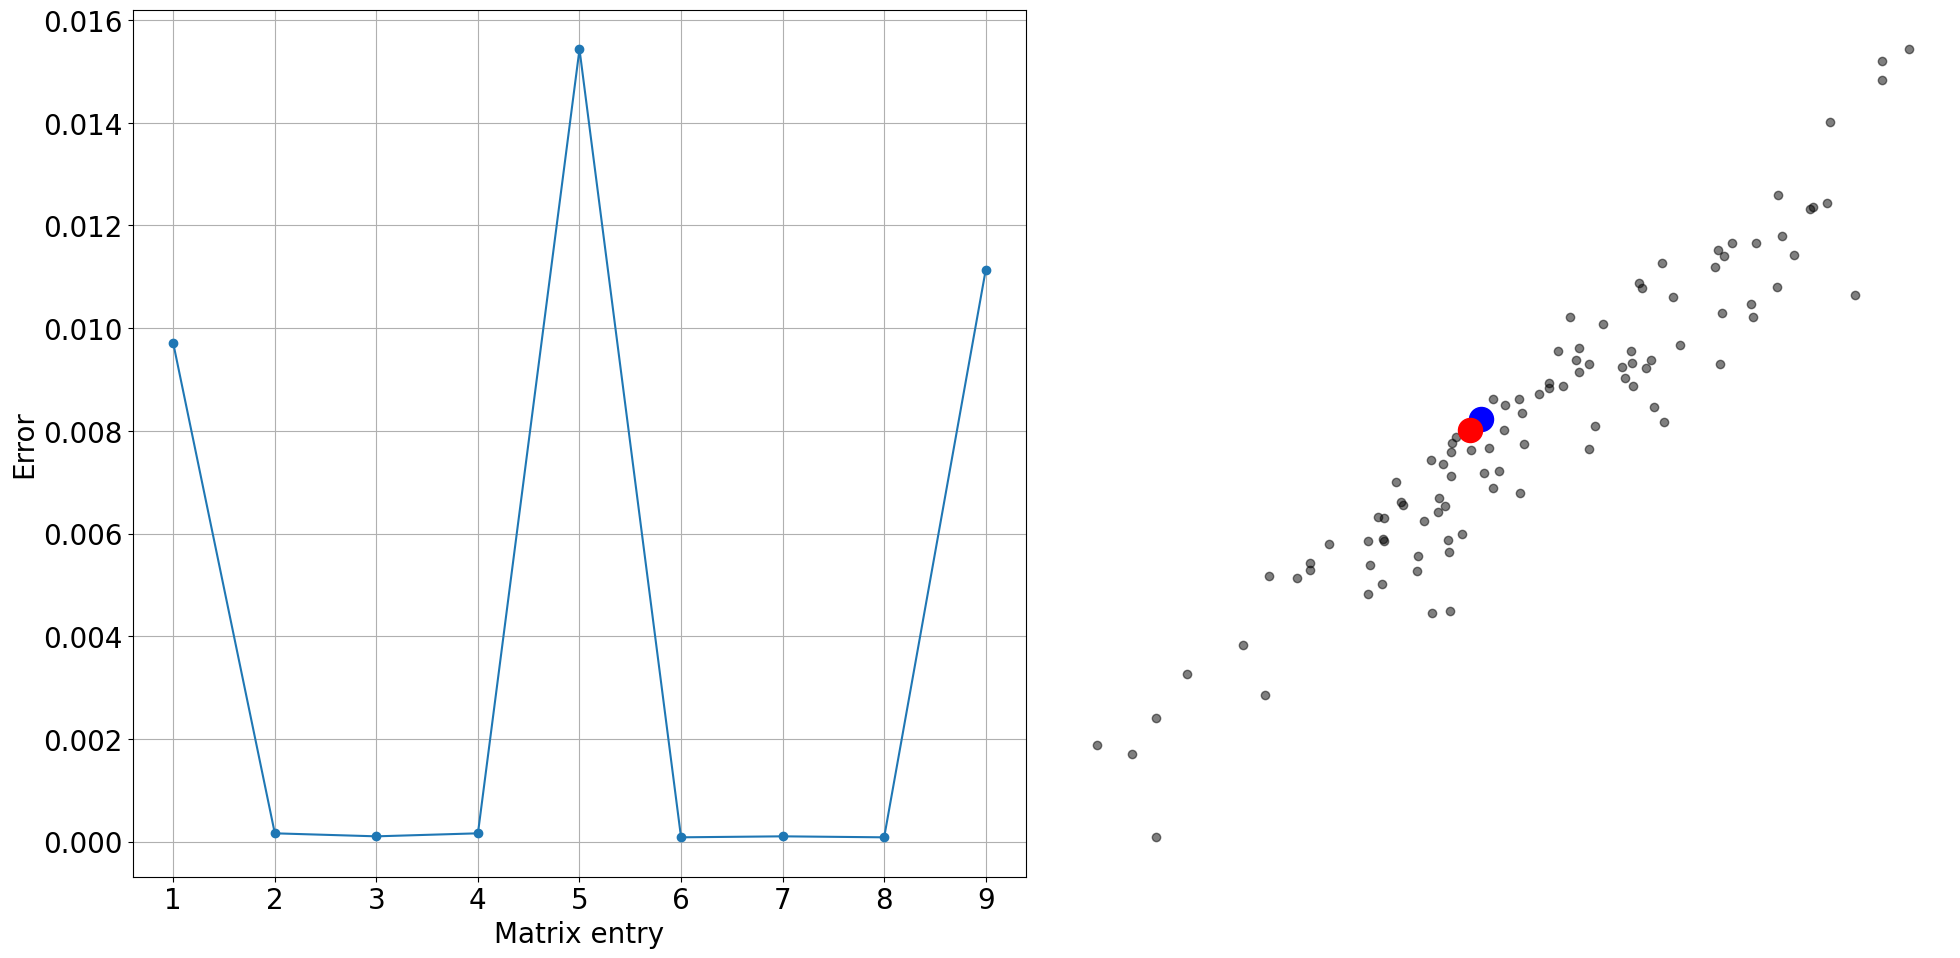

In [98]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121)
ax.plot(jnp.arange(1,10,1), error, '-o')
ax.set_xlabel(f'Matrix entry')
ax.set_ylabel(r'Error')
ax.grid(True)

ax = fig.add_subplot(122)
ax.scatter(dti_eigval1[:100,0], dti_eigval1[:100,1], color='black', alpha=.5)#c=dti_eig1[:100,2])
ax.scatter(spdn_mu1_score_eigval[0], spdn_mu1_score_eigval[1], color='blue', s=300)#c=dti_eig1[:100,2])
ax.scatter(spdn_mu1_true_eigval[0], spdn_mu1_true_eigval[1], color='red', s=300)#c=dti_eig1[:100,2])
ax.set_axis_off()

fig.tight_layout()

fig.savefig(f'{figure_path}score_frechet_spdn_error.eps', format='eps', pad_inches=0.1, bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


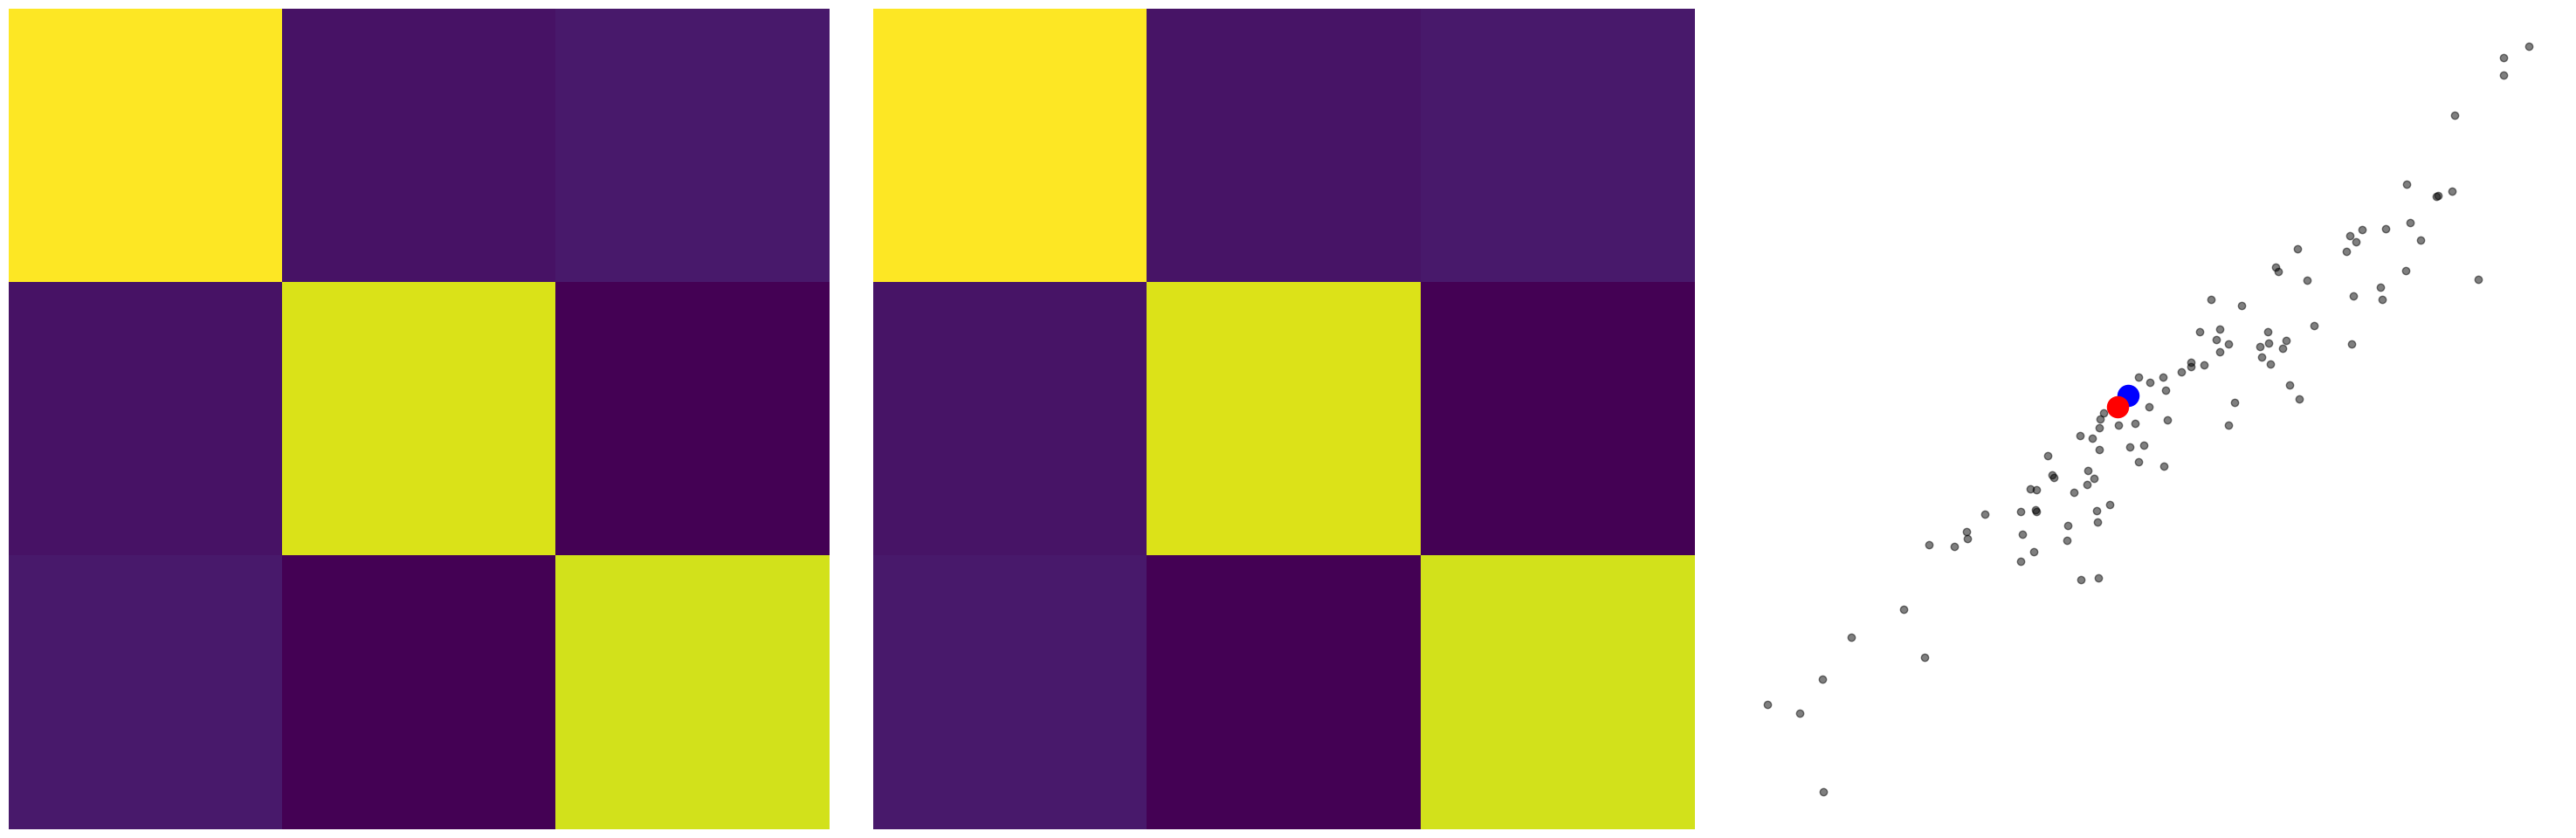

In [97]:
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(131)
ax.imshow(spdn_mu1_true_frechet[1][-1].reshape(3,3), cmap=mpl.cm.viridis)
ax.set_axis_off()

ax = fig.add_subplot(132)
ax.imshow(spdn_mu1_score_frechet[1][-1].reshape(3,3), cmap=mpl.cm.viridis)
ax.set_axis_off()

ax = fig.add_subplot(133)
ax.scatter(dti_eigval1[:100,0], dti_eigval1[:100,1], color='black', alpha=.5)#c=dti_eig1[:100,2])
ax.scatter(spdn_mu1_score_eigval[0], spdn_mu1_score_eigval[1], color='blue', s=300)#c=dti_eig1[:100,2])
ax.scatter(spdn_mu1_true_eigval[0], spdn_mu1_true_eigval[1], color='red', s=300)#c=dti_eig1[:100,2])
ax.set_axis_off()

fig.tight_layout()

fig.savefig(f'{figure_path}score_frechet_spdn.eps', format='eps', pad_inches=0.1, bbox_inches='tight')


## $\mathbb{S}^{2}$

In [38]:
M, x0, ScoreEval = load_score_model("Sphere", 2)

using M.Exp for Logarithm


In [39]:
data_path = '../../../Data/sphere_walking/sphere_walking.mat'

In [40]:
mat = sio.loadmat(data_path)

In [41]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

In [42]:
s2_data =  mat['data']

s2_obs = jnp.array(s2_data).T
s2_obs = vmap(lambda x: (M.invF((x,x)), x))(s2_obs)

In [82]:
t0 = 0.01
dm_score(M, s1_model=lambda x,y,t: ScoreEval.grady_log(x,y,t)/jnp.linalg.norm(ScoreEval.grady_log(x,y,t)), 
         s2_model = ScoreEval.gradt_log, method="Gradient")
s2_score_frechet = M.sm_dmx((s2_obs[0], s2_obs[1]), 
                                     (s2_obs[0][0], s2_obs[1][0]), 
                                     t0, 
                                     step_size=0.01, max_iter=1000)[0]

In [74]:
t0 = 0.01
dm_score(M, s1_model=lambda x,y,t: M.Log(y,x[1]), s2_model = ScoreEval.gradt_log, method="Gradient")
s2_frechet = M.sm_dmx((s2_obs[0], s2_obs[1]), 
                                     (s2_obs[0][0], s2_obs[1][0]), 
                                     t0, 
                                     step_size=0.1, max_iter=1000)[0]

In [83]:
s2_score_frechet

(Array([[-7.74150642e-18, -2.64262773e-17],
        [ 5.99585555e-18, -0.00000000e+00],
        [-4.43036690e-18, -0.00000000e+00],
        ...,
        [ 3.39918736e-18, -0.00000000e+00],
        [ 6.45217631e-18, -0.00000000e+00],
        [-4.46702539e-18,  2.68272032e-17]], dtype=float64),
 Array([[0.75929711, 0.47006306, 0.45000957],
        [0.75759273, 0.4672135 , 0.45581223],
        [0.7558922 , 0.46437219, 0.46150346],
        ...,
        [0.26916544, 0.08750386, 0.95911055],
        [0.26909559, 0.08751259, 0.95912935],
        [0.26902594, 0.08752129, 0.95914809]], dtype=float64))

In [76]:
s2_frechet

(Array([[ 2.49228135e-18,  0.00000000e+00],
        [ 1.44274545e-17,  0.00000000e+00],
        [ 2.86996152e-18,  0.00000000e+00],
        ...,
        [-8.97200673e-19, -0.00000000e+00],
        [-8.97200673e-19, -0.00000000e+00],
        [-8.97200673e-19, -0.00000000e+00]], dtype=float64),
 Array([[0.72413672, 0.46609832, 0.50830932],
        [0.68632964, 0.45637983, 0.5662765 ],
        [0.64829781, 0.44441351, 0.61822859],
        ...,
        [0.04050196, 0.03721566, 0.99848615],
        [0.04050196, 0.03721566, 0.99848615],
        [0.04050196, 0.03721566, 0.99848615]], dtype=float64))

In [77]:
# Creating the theta and phi values.
intervals = 100

theta = jnp.linspace(0.0, jnp.pi*1, intervals)
phi   = jnp.linspace(0.0, jnp.pi*2, intervals)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(intervals))

X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, intervals, intervals), 
                     X2_S2.reshape(1, intervals, intervals), 
                     X3_S2.reshape(1, intervals, intervals))), axes=(1,2,0))

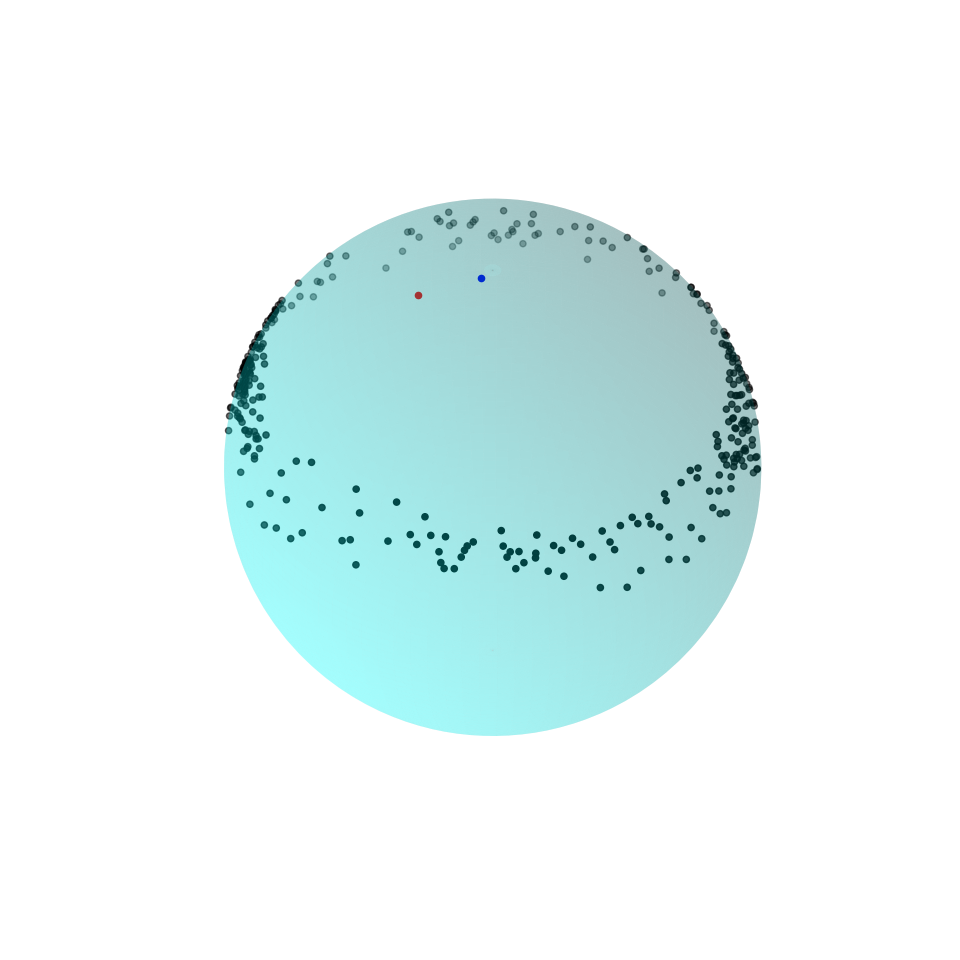

In [84]:
color = ['magenta', 'red', 'green', 'orange', "blue"]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1_S2, X2_S2, X3_S2, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(s2_score_frechet[1][-1,0], s2_score_frechet[1][-1,1], s2_score_frechet[1][-1,2], color='red')
ax.scatter(s2_obs[1][:,0], s2_obs[1][:,1], s2_obs[1][:,2], color='black')
ax.scatter(s2_frechet[1][-1,0], s2_frechet[1][-1,1], s2_frechet[1][-1,2], color='blue')
#ax.text(s1_train_euler[idx1,0],s1_train_euler[idx1,1],s1_train_euler[idx1,2],  '1', size=100, zorder=1,  
#    color='red', ha='left')
#ax.text(s1_train_euler[idx2,0],s1_train_euler[idx2,1],s1_train_euler[idx2,2],  '2', size=100, zorder=1,  
#    color='red', ha='left')
#ax.text(s1_train_euler[idx3,0],s1_train_euler[idx3,1],s1_train_euler[idx3,2],  '3', size=100, zorder=1,  
#    color='red', ha='left')
ax.set_box_aspect([1,1,1])
ax.autoscale(False)
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.grid(False)
ax.view_init(elev=45., azim=90)

fig.tight_layout()

#fig.savefig(f'{figure_path}rm_kmeans_head_pose_s2.pdf', format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()
